# Algorithm refactoring

## Layout

```
QuICT/algorithm/quantum_algorithm/
├── __init__.py
├── grover
│   ├── __init__.py
│   ├── grover.py
│   ├── partial_grover.py
│   └── search_with_prior_knowledge.py
└── shor
    ├── __init__.py
    ├── BEA.py
    ├── BEA_zip.py
    ├── HRS.py
    ├── HRS_zip.py
    ├── shor_factor.py
    └── utility.py
```

In [23]:
from QuICT.core.gate import *
from QuICT.simulation.gpu_simulator import ConstantStateVectorSimulator

import random
random.seed(2022)

## Grover Module

This Module implements the most basic (partial) Grover search algorithm.[1][2]

- bug fix: use `MCTOneAux` instead of `MCTLinearOneDirtyAux` to avoid unexpected behaviour

The overall circuit for Grover search which uses $\lceil\frac{\pi}{4}\sqrt{N}\rceil$ oracle calls for large $N$:

![circuit](./basic_Grover_circuit.png)

Phase part which uses $O(n)=O(\log N)$ elementary gates (with MCT implemented in $O(n)$ elementary gates and 1 ancillary qubit[5]):

![phase-circuit](./phase_circuit.png)

Partial Grover search use local Grover operation along with global Grover iteration (more specifically, form of input oracle is limited to ensure a xor-oracle can be easily constructed based on the input oracle):

![partial-grover-circuit](./partial_Grover_circuit.png)

And local Grover operation is shown below:

![local-grover-iter](./local_g_iter_circuit.png)

### example

Consider solving a 2×2 binary sudoku that

- No column may contain the same value twice
- No row may contain the same value twice

![binary_sudoku](./binary_sudoku.png)

i.e. 

$$f(x)=[(x_0\oplus x_1) \& (x_2\oplus x_3) \& (x_0\oplus x_2) \& (x_1\oplus x_3)]$$

To start with, we construct the oracle $O\ket{x}=(-1)^{f(x)}\ket{x}$: 输出振幅分布（图形化）实际上也包含了成功率的信息

In [24]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from QuICT.algorithm.quantum_algorithm.grover import Grover,PartialGrover
from QuICT.qcda.synthesis.mct import MCTOneAux

def sudoku_oracle():
    clauses_list = [[0,1],[2,3],[0,2],[1,3]]
    var_q = list(range(4))
    clause_q = list(range(4,8))
    result_q = [8]
    ancilla_q = [9]
    cgate = CompositeGate()
    with cgate:
        # |-> in result_q
        X & result_q[0]
        H & result_q[0]
        # sentence
        for i in range(len(clauses_list)):
            CX & [var_q[clauses_list[i][0]],clause_q[i]]
            CX & [var_q[clauses_list[i][1]],clause_q[i]]
        MCTOneAux.execute(5+1) & (clause_q+result_q+ancilla_q)
        # un-compute
        for i in range(len(clauses_list)):
            CX & [var_q[clauses_list[i][0]],clause_q[i]]
            CX & [var_q[clauses_list[i][1]],clause_q[i]]
        H & result_q[0]
        X & result_q[0]
    return 6, cgate

The circuit of the oracle:

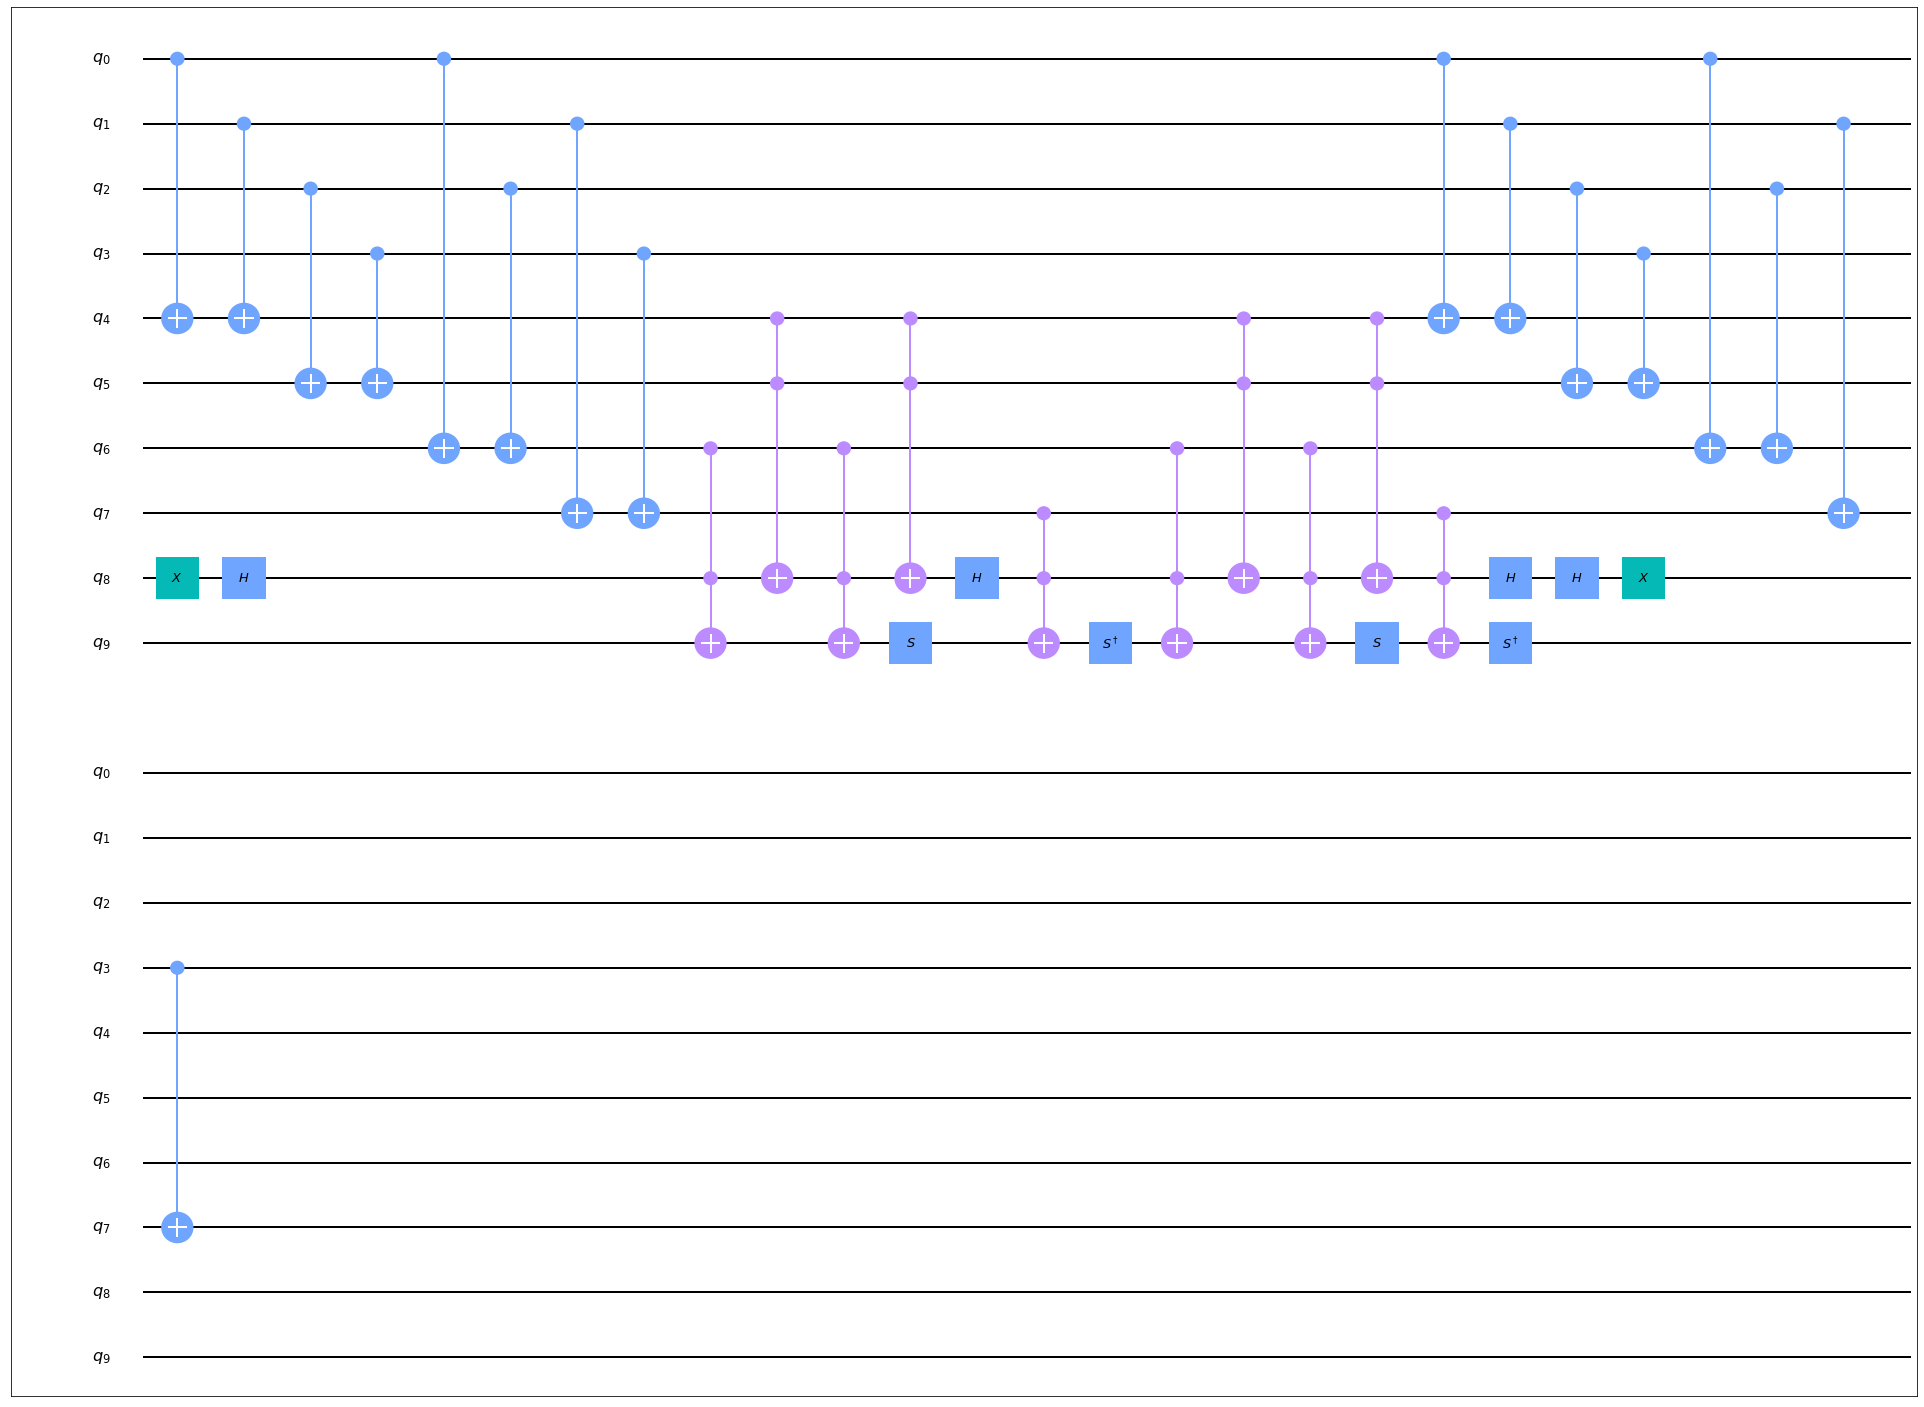

In [25]:
from QuICT.core import Circuit
k,cgate = sudoku_oracle()
circ = Circuit(10)
cgate | circ
circ.draw()

Construct Grover search circuit on oracle with $f(x)=[x=target]$ and run:

In [26]:
n = 4
k, oracle = sudoku_oracle()
circ = Grover.circuit(n, k, oracle, m=2)

from QuICT.simulation.cpu_simulator import CircuitSimulator
amp = CircuitSimulator().run(circ)
x = bin(int(circ[list(range(n))]))[2:].rjust(4,'0')[::-1]
print(f'{x[0]}|{x[1]}\n-+-\n{x[2]}|{x[3]}')

INFO:root:circuit width          =   10
INFO:root:oracle  calls          =    2
INFO:root:other circuit size     =   64


1|0
-+-
0|1


Construct Partial Grover search circuit on same oracle and run: 做成表格对比一下（电路中oracle次数、电路大小、振幅分布）；提一下partial grover解决的问题和原始问题的区别

In [ ]:
n = 4
n_block = 3
print(f"run with n = {n}, block size = {n_block}")
k, oracle = sudoku_oracle()
circ = PartialGrover.circuit(n, n_block, k, oracle)

ConstantStateVectorSimulator().run(circ)
result = int(circ[list(range(n))])
result_bin = bin(result)[2:].rjust(n,'0')[::-1]
print(f"result {result}({result_bin}) in block {result_bin[:n_block]}")
print(f'{result_bin[0]}|{result_bin[1]}\n---\n{result_bin[2]}|*')

INFO:root:circuit width          =   13
INFO:root:oracle  calls          =   21
INFO:root:other circuit size     = 2038


run with n = 10, block size = 3
target 632(1001111000) in block 100
result 632(1001111000) in block 100


Partial search uses fewer Oracle calls and only guarantees to find block address:

```
run with n = 10, block size = 3
target 650(1010001010) in block 101
result 693(1010110101) in block 101
```

## Shor Module

This module includes four implementations of Shor factoring algorithm[3][4], which differs in the operator $U\ket{y}\equiv \ket{xy(\text{mod }N)}$ and usage of one-bit trick. 

-  `circuit` method support by using `Trigger` operator
- bug fix: little-endian IQFT/QFT in arithmetic circuit and big-endian IQFT/QFT in QPE circuit
- bug fix: use $CU1(\theta) = \begin{bmatrix}
 1 & 0 & 0 & 0\\ 
 0 & 1 & 0 & 0\\ 
 0 & 0 & 1 & 0\\ 
 0 & 0 & 0 & e^{i\theta}
\end{bmatrix}$ instead of
$CR_z(\theta) = \begin{bmatrix}
 1 & 0 & 0 & 0\\ 
 0 & 1 & 0 & 0\\ 
 0 & 0 & e^{-i\theta/2} & 0\\ 
 0 & 0 & 0 & e^{i\theta/2}
\end{bmatrix}$ in QFT/IQFT

The quantum part of Shor's factoring algorithm is the order-finding circuit, which can be split into Quantum Phase Estimation (QPE) circuit and modular exponentiation circuit. By using two different constructions of QPE circuit (with or without the one-qubit-trick) and two different constructions of modular exponentiation circuit (in `QuICT.qcda.synthesis.arithmetic.bea` and `QuICT.qcda.synthesis.arithmetic.hrs`), four implementations of Shor's factoring algorithm is given. 

QPE with one-bit trick:

![one-bit](./one_bit_trick.png)

### example

Use `ShorFactor(mode, N).run()` to factor a number $N$: 包含完整的内容（order-finding、经典处理（例如连分数分解））；成功概率分析和展示（最终输出是否为输入的因子）

In [ ]:
logger.setLevel(logging.WARNING)

from QuICT.algorithm.quantum_algorithm import ShorFactor

input  = 35
sf = ShorFactor(mode="BEA_zip", N=input)
circ, indices = sf.circuit()

output = sf.run(simulator=ConstantStateVectorSimulator(), circuit=circ, indices=indices)
print(f"input  = {input}")
print(f"output = {output}")

input  = 35
output = 5


More specificly, the order-finding circuit will run serval times and the output will be least common multiple of results.
```
>>> output = ShorFactor(mode="BEA_zip", N=21).run(simulator=ConstantStateVectorSimulator())
INFO:root:      circuit construction begin: circuit: n = 5 t = 13
INFO:root:round = 0
INFO:root:Quantumly determine the order of the randomly chosen a = 11
INFO:root:      order_finding begin: circuit: n = 5 t = 13
INFO:root:      phi~ (approximately s/r) in decimal form is 0.1666259765625
INFO:root:      Continued fraction expansion of phi~ is 1/6
INFO:root:      success!
INFO:root:      order_finding begin: circuit: n = 5 t = 13
INFO:root:      phi~ (approximately s/r) in decimal form is 0.3333740234375
INFO:root:      Continued fraction expansion of phi~ is 1/3
INFO:root:      order_finding begin: circuit: n = 5 t = 13
INFO:root:      phi~ (approximately s/r) in decimal form is 0.33349609375
INFO:root:      Continued fraction expansion of phi~ is 1/3
INFO:root:Shor succeed: found factor 7, with the help of a = 11, r = 6
```

Not recomended though, one can construct order-finding circuit and then run it on $(p, N)$ where $gcd(p, N)=1$:

In [ ]:
from fractions import Fraction
from math import gcd
from QuICT.algorithm.quantum_algorithm.shor.BEA_zip import construct_circuit as BEA_construct_circuit

def naive_order_finding(a, N):
    for i in range(1, N):
        if (a ** i) % N == 1:
            return i
    return 0

N = 35
simulator = ConstantStateVectorSimulator()
p = random.choice(list(filter(lambda x: gcd(x, N) == 1, list(range(N)))))
print(f"testing ({p:2},{N:2})...")
circ, indices = BEA_construct_circuit(p, N)
simulator.run(circ)
phi = eval("0b" + "".join([str(trig.measured[0]) for trig in indices])) / (
    1 << len(indices)
)
print(f"phi = {phi:.5f}")
result = Fraction(phi).limit_denominator(N - 1).denominator
print(f"target = {naive_order_finding(p, N)}")
print(f"result = {result}")

testing (22,35)...
phi = 0.25000
target = 4
result = 4


### Error rate

The behaviour of order-finding algorithm is consistent with theoretical prediction. 

| mode    | original   | reinforced(MAX_ROUND=3)         | $Pr(r\neq 0\text{ and }r\nmid\text{order}(a,N))$  | repetitions |
| ------- | ---------- | ------------------------------- | ---------------------------------------- |---------------|
| BEA     | 0.47       | 0.12                            | 0                                        | 108 |
| BEA_zip | 0.48       | 0.11                            | 0                                        | 108 |
| HRS     | 0.44       | 0.06                            | 0                                        | 108 |
| HRS_zip | 0.44       | 0.03                            | 0                                        | 108 |

## References

[1] Nielsen, M. A., & Chuang, I. L. (2019). Quantum computation and quantum information. Cambridge Cambridge University Press.

[2] Grover, L. K., & Radhakrishnan, J. (2005). Is partial quantum search of a database any easier? Proceedings of the 17th Annual ACM Symposium on Parallelism in Algorithms and Architectures - SPAA’05. https://doi.org/10.1145/1073970.1073997

[3] Beauregard, S. (2003). Circuit for Shor’s algorithm using 2n+3 qubits. Quantum Information and Computation, 3(2), 175–185. https://doi.org/10.26421/qic3.2-8

[4] Haner, T., Roetteler, M., & Svore, K. M. (2017). Factoring using 2n+2 qubits with Toffoli based modular multiplication. Quantum Information and Computation, 17(7&8), 673–684. https://doi.org/10.26421/qic17.7-8-7

[5] He, Y., Luo, MX., Zhang, E. et al. (2017). Decompositions of n-qubit Toffoli Gates with Linear Circuit Complexity. Int J Theor Phys, 56, 2350–2361. https://doi.org/10.1007/s10773-017-3389-4